$$\text{Applied Machine Learning in Python}$$
$$\text{week 8}$$

* Ensemble learning
    * Bagging 
    * Boosting
    * Random forest
* Principal Component Analysis
* Pipelines

$$\textbf{Ensemble (meta) learninig}$$

**Ensemble methods (learning)** are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking).

Ensemble methods can be classified as:
* **sequential** - to exploit the dependence between the base learners 
  * _boosting, mixture of experts_
* **parallel** - to exploit independence between the base learners, as the error can be reduced by averaging
  * _Bagging (bootstrap aggregation), Cross-validated committees_

Typical approach: 
* Generate multiple classifiers 
* Each votes on test instance 
* Take majority as classification (or average for regression)

Classifiers are different due to different sampling of training data, or randomised parameters within the classification algorithm. 

**The motivation:** take a simple mediocre algorithm and transform it into a powerful classifer without requiring any new algorithm.

**Bagging (Bootstrap AGGregatING)**

Algorithm:
* Given a standard training set _D_ of size _n_, generate _m_ new training sets $D_{i}$, $(i=1,.., m)$ each of size _n_, by sampling from D uniformly and with replacement.
* Fit _m_ models using bootstrapped $D_{i}$
* Combined by averaging the output (for regression) or voting (for classification)

<img src="plots/bagging.png"  align="center" style="width: 500px;"/>

**The error of an ensemble:**
Consider a collection of _M_ base classifier for a binary classification problem and all classifiers have the same classification error $\epsilon$. Also, we assume that the classifiers are independent and the error rates are not correlated. Then, the probability that at least _k_ of _N_ base classifiers are wrong:

$$P(\text{k errors}) = \binom{N}{k} \epsilon^k (1-\epsilon)^{N-k}$$

_(The entire ensemble is wrong if more than $N/2$ base classifiers are wrong)_. This is the Binomial distribution.

**Example:**
Consider 10 base classifiers (logistic regressions, for example), each with an error rate $\epsilon=0.25$ _(accuracy = 1-error = 0.75)_.
If at least 6 classifiers are wrong, then the entire ensemble will be wrong. Probability that 6 classifiers are wrong:
$$P(k=6) = \sum_{k=6}^{10} \binom{10}{k} 0.25^k (1-0.25)^{10-k} = 0.019$$

The estimation of the ensemble error rate is the same as asking what is the probability of achieving at leaset 6 heads after 10 tosses of an unfair coin with probability of a head $\epsilon$.

In [43]:
# standard import
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import *
from sklearn.datasets import *
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [46]:
# data
iris_data = load_iris()
X, y = iris_data.data[:,:2], iris_data.target
# import the meta-classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# bagging with KNN classifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf_knn = KNeighborsClassifier(n_neighbors=12)    
clf_bagging_tree = BaggingClassifier(base_estimator=clf_tree, n_estimators=10, max_samples=0.8, max_features=0.8)
clf_bagging_knn = BaggingClassifier(base_estimator=clf_knn, n_estimators=10, max_samples=0.8, max_features=0.8)

In [52]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf_tree, clf_knn, clf_bagging_tree, clf_bagging_knn]

def plot_baggings(clf_list, label, grid):
    for clf, label, grd in zip(clf_list, label, grid):        
        scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
        print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)

        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title(label)
    plt.show()
    return 0

<Figure size 720x576 with 0 Axes>

Accuracy: 0.62 (+/- 0.05) [Decision Tree]
Accuracy: 0.77 (+/- 0.08) [K-NN]
Accuracy: 0.68 (+/- 0.08) [Bagging Tree]
Accuracy: 0.74 (+/- 0.14) [Bagging K-NN]


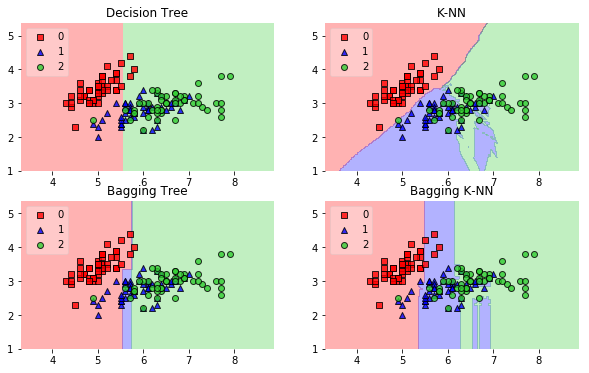

In [58]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)
plot_baggings(clf_list, label, grid);

The decision tree bagging ensemble achieved better accuracy compared to KNN bagging ensemble. This is due to the fact, that KNN are less sensitive to perturbation in training samples and therefore they are called _stable learners_. Combining stable learners is not beneficial, as their ensemble will not help to improve generalisation error.

**Boosting**

In boosting, the ensemble consists of very simple base classifiers, also often referred to as weak learners, that have only a slight performance advantage over random guessing. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were misclassified by earlier rounds. The main difference between boosting and bagging is that base learners are trained sequentially on a weighted version of the data.

$$Clf(x) = \sum_i w_i clf_i(x)$$

where $Clf(x)$ is the resulting boosted classifier and $clf_i(x)$ is a base weak classifier.

<img src="plots/adaboost.png"  align="center" style="width: 1000px;"/>

In [61]:
# import AdaBoost
from sklearn.ensemble import AdaBoostClassifier

In [64]:
def plot_adaboost(clf_i, num_est, label, grid):
    for n_est, label, grd in zip(num_est, label, grid):     
        boosting = AdaBoostClassifier(base_estimator=clf_i, n_estimators=n_est)   
        boosting.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
        plt.title(label)

    plt.show()
    return 0

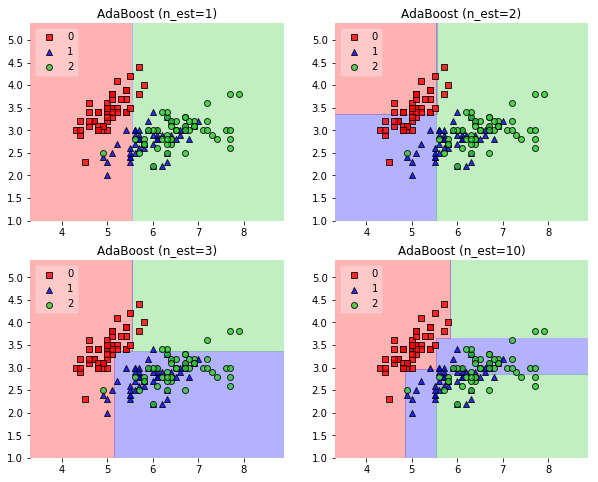

0

In [66]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)
plot_adaboost(clf_tree, num_est, label, grid)

**Random Forest**
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

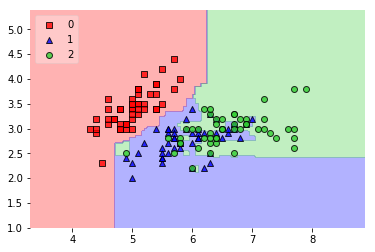

In [71]:
# import random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)
clf_rf.fit(X,y)
plot_decision_regions(X=X, y=y, clf=clf_rf, legend=2);

In [78]:
print cross_val_score(estimator=clf_rf, X=X, y=y, cv=StratifiedKFold(n_splits=5)).mean()

0.7333333333333334


$$\textbf{Principal Component Analysis}$$

* Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
* Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components.
* The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible.

<img src="plots/PCA_0.jpg"  align="center" style="width: 400px;"/>

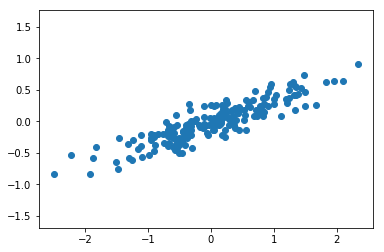

In [108]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [109]:
# import PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X);

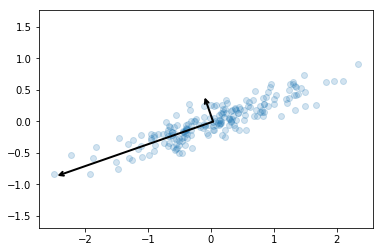

In [110]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
    linewidth=2,
    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    plt.axis('equal');
plt.show()

In [111]:
print pca.components_

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [112]:
print pca.explained_variance_

[0.7625315 0.0184779]


In [113]:
print pca.explained_variance_ratio_

[0.97634101 0.02365899]


**PCA of Iris data set**

In [155]:
X, y = iris_data.data, iris_data.target
pca = PCA()
pca.fit(X);

In [157]:
print pca.explained_variance_ratio_.cumsum()

[0.92461621 0.97763178 0.99481691 1.        ]


In [116]:
# transform the original data with PCA
X_pca = pca.transform(X)

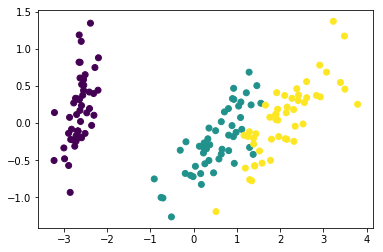

In [117]:
# plot first two components
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)

In [120]:
grid_serch_cv = GridSearchCV(estimator=LogisticRegression(), param_grid={'C':np.logspace(-3,2,20)}, cv=5)
grid_serch_cv.fit(X_pca[:,:2],y);

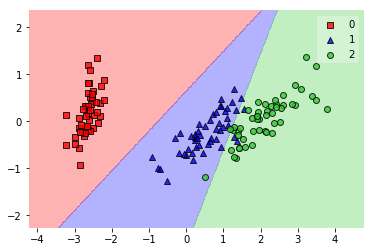

In [119]:
plot_decision_regions(X=X_pca[:,:2], y=y, clf=grid_serch_cv.best_estimator_);

**PCA for handwritten digits**

In [122]:
# import data
digits = load_digits()
# project from 64 to 2 dimensions
pca = PCA(2) 
projected = pca.fit_transform(digits.data)

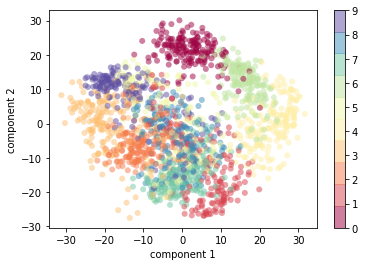

In [125]:
plt.scatter(projected[:, 0], projected[:, 1], 
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

The full data set is a 64-dimensional point cloud, and these points are the 2D projection of each data point along the directions with the largest variance.

**Kernel PCA**

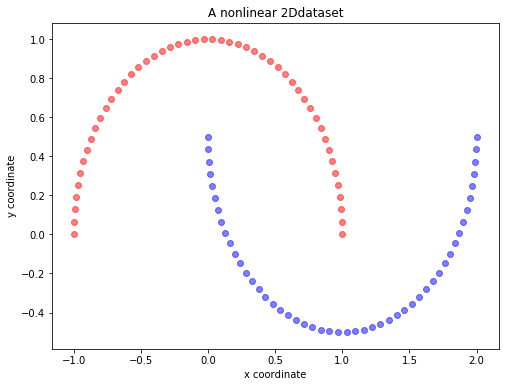

In [128]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

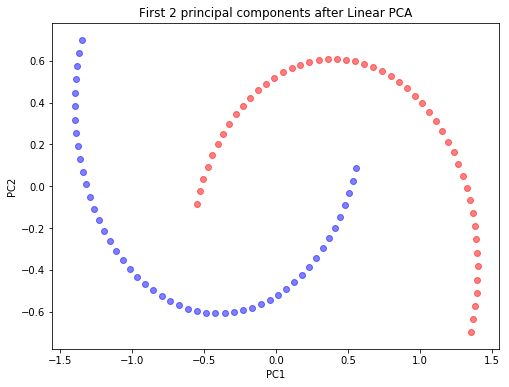

In [129]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

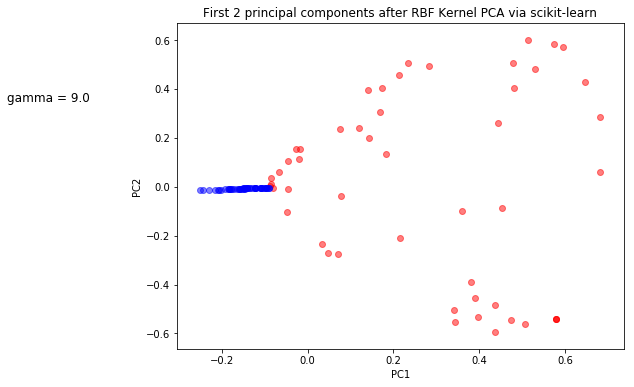

In [160]:
from sklearn.decomposition import KernelPCA

# parameters
gamma_i = 9.0

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_i)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', alpha=0.5)

plt.text(-0.7, 0.35, 'gamma = '+str(gamma_i), fontsize=12)
plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

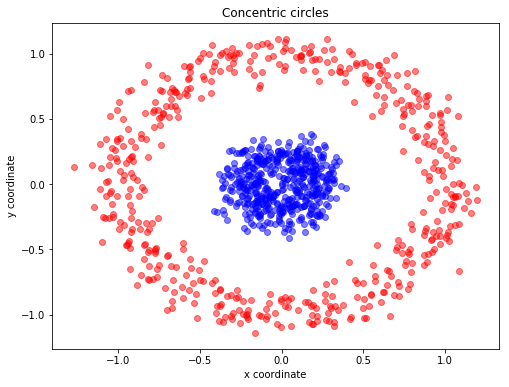

In [145]:
# circles
from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,6))

plt.scatter(X_circ[y_circ==0, 0], X_circ[y_circ==0, 1], color='red', alpha=0.5)
plt.scatter(X_circ[y_circ==1, 0], X_circ[y_circ==1, 1], color='blue', alpha=0.5)
plt.title('Concentric circles')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

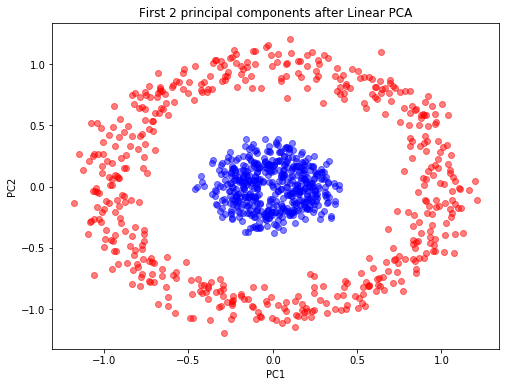

In [146]:
scikit_pca = PCA(n_components=2)
X_spca_circ = scikit_pca.fit_transform(X_circ)

plt.figure(figsize=(8,6))
plt.scatter(X_spca_circ[y_circ==0, 0], X_spca_circ[y_circ==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca_circ[y_circ==1, 0], X_spca_circ[y_circ==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

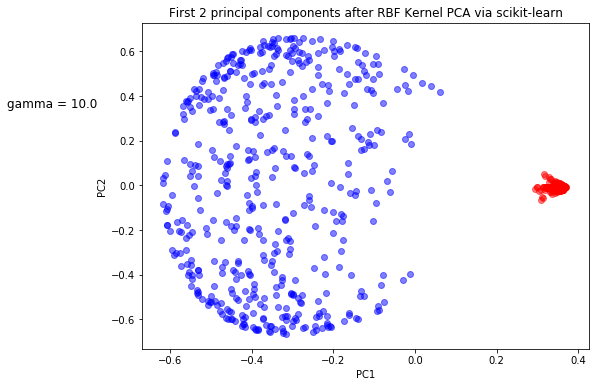

In [153]:
# parameters
# parameters
gamma_i = 10.0

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_i)
X_skernpca_circ = scikit_kpca.fit_transform(X_circ)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca_circ[y_circ==0, 0], X_skernpca_circ[y_circ==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca_circ[y_circ==1, 0], X_skernpca_circ[y_circ==1, 1], color='blue', alpha=0.5)

plt.text(-1.0, 0.35, 'gamma = '+str(gamma_i), fontsize=12)
plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()